# ALOS inventory from ASF VERTEX - Boise

NOTES: 

- unlike ERS and ENVISAT from ESA, no baseline data provided

https://vertex.daac.asf.alaska.edu

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import geopandas as gpd
import shapely
import requests
import os
import json
import shapely.wkt

In [23]:
plt.style.use('seaborn-white')
plt.rcParams['font.size'] = 14
%matplotlib inline
#%qtconsole

In [24]:
def ogr2snwe(vectorFile, buffer=None):
    gf = gpd.read_file(vectorFile)
    gf.to_crs(epsg=4326, inplace=True)
    poly = gf.geometry.convex_hull
    if buffer:
        poly = poly.buffer(buffer)
    W, S, E, N = poly.bounds.values[0]
    snwe = [S, N, W, E]

    return snwe

In [86]:
def query_asf(snwe, sat='ALOS', format='json'):
    print(f'Querying ASF Vertex for {sat}...')
    miny, maxy, minx, maxx = snwe
    roi = shapely.geometry.box(minx, miny, maxx, maxy)
    polygonWKT = roi.to_wkt()

    baseurl = 'https://api.daac.asf.alaska.edu/services/search/param'
    # relativeOrbit=$ORBIT
    data = dict(intersectsWith=polygonWKT,
                platform=sat,
                processingLevel='L1.0', #NOTE it seems there are radiometric terrain corrected ALOS! RT
                #'KMZ', 'L1.5', 'RTC_LOW_RES', 'RTC_HI_RES', 'L1.0', 'L1.1'],
                #beamMode='IW',
                output=format)

    r = requests.get(baseurl, params=data, timeout=100)
    print(r.url)
    with open(f'query_{sat}.{format}', 'w') as j:
        j.write(r.text)

In [87]:
def save_inventory(gf, outname='query.geojson', format='GeoJSON'):
    # WARNING: overwrites existing file
    if os.path.isfile(outname):
        os.remove(outname)
    # NOTE: can't save pandas Timestamps!
    # ValueError: Invalid field type <class 'pandas._libs.tslib.Timestamp'>
    gf.drop(['timeStamp', 'dateStamp'], axis=1, inplace=True)
    gf.to_file(outname, driver=format)
    print('Saved inventory: ', outname)

In [88]:
def load_asf_json(jsonfile: str):
    with open(jsonfile) as f:
        meta = json.load(f)[0]  # list of scene dictionaries

    df = pd.DataFrame(meta)
    #print(df.keys())
    polygons = df.stringFootprint.apply(shapely.wkt.loads)
    gf = gpd.GeoDataFrame(df,
                          crs={'init': 'epsg:4326'},
                          geometry=polygons)

    gf['timeStamp'] = pd.to_datetime(gf.sceneDate, format='%Y-%m-%d %H:%M:%S')
    gf['sceneDateString'] = gf.timeStamp.apply(
                                            lambda x: x.strftime('%Y-%m-%d'))
    gf['dateStamp'] = pd.to_datetime(gf.sceneDateString)
    gf['utc'] = gf.timeStamp.apply(lambda x: x.strftime('%H:%M:%S'))
    gf['orbitCode'] = gf.relativeOrbit.astype('category').cat.codes

    return gf

In [89]:
AOI = '/Users/scott/Documents/GitHub/snowex/snowex2019/ca-id-ut/Name_BOI1EW_232aa.shp'

In [90]:
# Query ASF for ALOS data based on shapefile
snwe = ogr2snwe(AOI)
query_asf(snwe, sat='ALOS', format='json')
jsonfile = 'query_ALOS.json'
gf = load_asf_json(jsonfile)

Querying ASF Vertex for ALOS...
https://api.daac.asf.alaska.edu/services/search/param?intersectsWith=POLYGON+%28%28-114.9939796712569660+43.6396165871749986%2C+-114.9939796712569660+44.4102482023349978%2C+-116.2699920827959517+44.4102482023349978%2C+-116.2699920827959517+43.6396165871749986%2C+-114.9939796712569660+43.6396165871749986%29%29&platform=ALOS&processingLevel=L1.0&output=json


In [94]:
#gf.head()

In [95]:
#with pd.option_context('display.max_rows', None, 'display.max_columns', 3):
#    display(gf.iloc[0])

In [96]:
gf.beamMode.unique()

array(['PLR', 'FBS', 'WB1', 'FBD'], dtype=object)

In [97]:
gf.offNadirAngle.unique()

array(['21.5', '34.3', '27.1', '23.1'], dtype=object)

In [98]:
gf.processingLevel.unique()

array(['L1.0'], dtype=object)

In [99]:
# Get only FBD or FBS
gf = gf.query('beamMode == "FBS" or beamMode == "FBD"')

In [100]:
gf.groupby(['flightDirection','track','frameNumber']).sceneId.count()

flightDirection  track  frameNumber
ASCENDING        205    880             4
                 206    860            20
                        870            20
                        880            19
                 207    860            18
                        870            18
                        880            21
                 208    860            17
                        870            17
                        880            17
                 209    860            15
                        870            16
                        880            11
DESCENDING       536    2720            2
                        2730            2
                        2740            2
                 537    2720            4
                        2730            4
                        2740            4
                 538    2720            1
                        2730            1
                        2740            1
                 539    2720            

In [101]:
# First, only retain tracks with more than 10 coincident frames:

idx = gf.groupby(['track','frameNumber']).sceneId.transform('count').gt(10)

GF = gf[idx]

GF.groupby(['flightDirection','track','frameNumber']).sceneId.count()

flightDirection  track  frameNumber
ASCENDING        206    860            20
                        870            20
                        880            19
                 207    860            18
                        870            18
                        880            21
                 208    860            17
                        870            17
                        880            17
                 209    860            15
                        870            16
                        880            11
Name: sceneId, dtype: int64

In [102]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.io.img_tiles import GoogleTiles

In [103]:
def plot_map(gf, snwe, vectorFile=None, zoom=8):
    """Plot dinosar inventory on a static map.

    Parameters
    ----------
    gf :  GeoDataFrame
        A geopandas GeoDataFrame
    snwe : list
        bounding coordinates [south, north, west, east].
    vectorFile: str
        path to region of interest polygon
    zoom: int
        zoom level for WMTS

    """
    pad = 1
    S, N, W, E = snwe
    plot_CRS = ccrs.PlateCarree()
    geodetic_CRS = ccrs.Geodetic()
    x0, y0 = plot_CRS.transform_point(W-pad, S-pad, geodetic_CRS)
    x1, y1 = plot_CRS.transform_point(E+pad, N+pad, geodetic_CRS)

    fig, ax = plt.subplots(figsize=(8, 8), dpi=100,
                           subplot_kw=dict(projection=plot_CRS))

    ax.set_xlim((x0, x1))
    ax.set_ylim((y0, y1))
    url = 'http://tile.stamen.com/terrain/{z}/{x}/{y}.png'
    tiler = GoogleTiles(url=url)
    # NOTE: going higher than zoom=8 is slow...
    ax.add_image(tiler, zoom)

    states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='110m',
        facecolor='none')
    ax.add_feature(states_provinces, edgecolor='k', linestyle=':')
    ax.coastlines(resolution='10m', color='black', linewidth=2)
    ax.add_feature(cfeature.BORDERS)

    # Add region of interest polygon in specified
    if vectorFile:
        tmp = gpd.read_file(vectorFile)
        ax.add_geometries(tmp.geometry.values,
                          ccrs.PlateCarree(),
                          facecolor='none',
                          edgecolor='m',
                          lw=2,
                          linestyle='dashed')

    orbits = gf.relativeOrbit.unique()
    colors = plt.cm.jet(np.linspace(0, 1, orbits.size))

    for orbit, color in zip(orbits, colors):
        df = gf.query('relativeOrbit == @orbit')
        poly = df.geometry.cascaded_union

        if df.flightDirection.iloc[0] == 'ASCENDING':
            linestyle = '--'
            xpos, ypos = poly.centroid.x, poly.bounds[3]
        else:
            linestyle = '-'
            xpos, ypos = poly.centroid.x, poly.bounds[1]

        ax.add_geometries([poly],
                          ccrs.PlateCarree(),
                          facecolor='none',
                          edgecolor=color,
                          lw=2,
                          linestyle=linestyle)
        ax.text(xpos, ypos, orbit, color=color, fontsize=16, fontweight='bold',
                transform=geodetic_CRS)

    gl = ax.gridlines(plot_CRS, draw_labels=True,
                      linewidth=0.5, color='gray', alpha=0.5, linestyle='-')
    gl.xlabels_top = False
    gl.ylabels_left = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER

    plt.title('Orbital Footprints')
    plt.savefig('map.pdf', bbox_inches='tight')

In [104]:
def plot_timeline(gf, platform):
    """Plot dinosar inventory acquisitions as a timeline.

    Parameters
    ----------
    gf :  GeoDataFrame
        A geopandas GeoDataFrame

    """
    dfA = gf.query('platform == @platform')

    # Same colors as map
    orbits = gf.relativeOrbit.unique()
    colors = plt.cm.jet(np.linspace(0, 1, orbits.size))

    fig, ax = plt.subplots(figsize=(11, 8.5))
    plt.scatter(dfA.timeStamp.values, dfA.orbitCode.values,
                edgecolors=colors[dfA.orbitCode.values], facecolors='None',
                cmap='jet', s=60, label=f'{platform}')

    plt.yticks(gf.orbitCode.unique(), gf.relativeOrbit.unique())

    ax.xaxis.set_minor_locator(mdates.MonthLocator())
    ax.xaxis.set_major_locator(mdates.YearLocator())
    plt.legend(loc='lower right')
    plt.ylim(-1, orbits.size)
    plt.ylabel('Orbit Number')
    fig.autofmt_xdate()
    plt.title('Acquisition Timeline')
    plt.savefig('timeline.pdf', bbox_inches='tight')

/Users/scott/miniconda3/envs/py37/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/scott/miniconda3/envs/py37/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


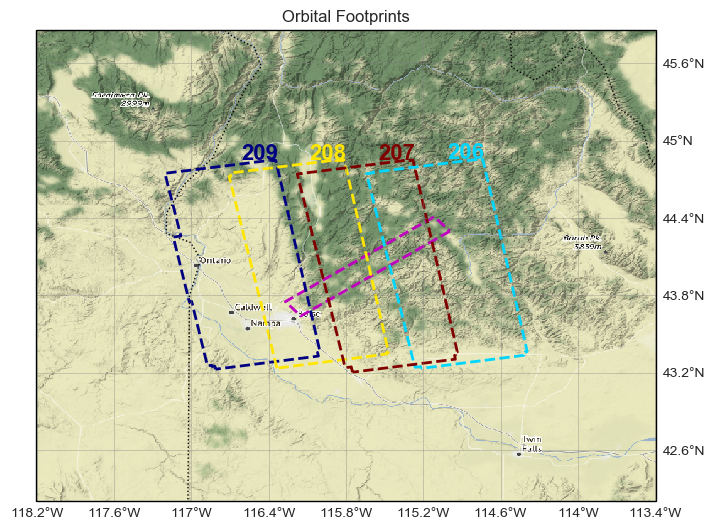

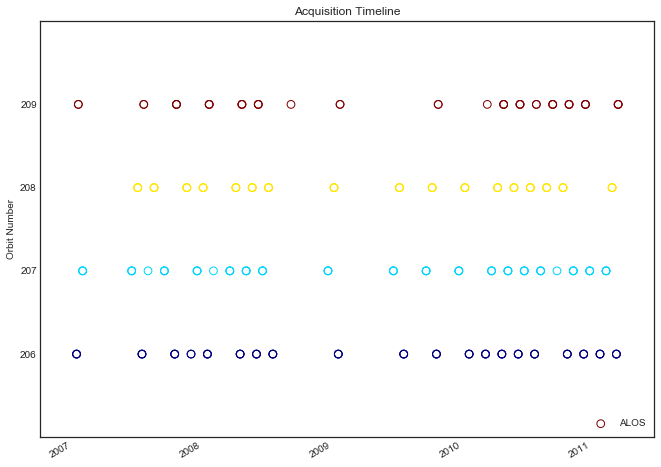

In [105]:
w, s, e, n = GF.geometry.cascaded_union.bounds
snwe = [s, n, w, e]

plot_map(GF, snwe, AOI)

GF['timeStamp'] = pd.to_datetime(GF.sceneDate)
GF['orbitCode'] = GF.relativeOrbit.astype('category').cat.codes
plat1= GF.platform.unique()[0]
plot_timeline(GF, plat1)

In [106]:
# Print list of scenes with FBD or FBS information
track = 209
frame = 870

# For some reason not stored as ints
GF['track'] = GF.track.astype('int')
GF['frame'] = GF.frameNumber.astype('int')

gf = GF.query('(track == @track) and (frame == @frame)').sort_values('timeStamp').reset_index(drop=True)

# Add time delta column
timeDeltas = gf.timeStamp.diff()
gf['dt'] = timeDeltas.dt.days
gf.loc[0, 'dt'] = 0
gf['dt'] = gf.dt.astype('i2')

/Users/scott/miniconda3/envs/py37/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/scott/miniconda3/envs/py37/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [107]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.max_colwidth', 10000):
    display(gf.loc[:, ['sceneId', 'sceneDateString', 'dt', 'beamMode', 'baselinePerp','downloadUrl']])#, 'timeStamp', 'geometry']

,sceneId,sceneDateString,dt,beamMode,baselinePerp,downloadUrl
0,ALPSRP052540870,2007-01-19,0,FBS,0,https://datapool.asf.alaska.edu/L1.0/A3/ALPSRP052540870-L1.0.zip
1,ALPSRP079380870,2007-07-22,184,FBD,2358.9404,https://datapool.asf.alaska.edu/L1.0/A3/ALPSRP079380870-L1.0.zip
2,ALPSRP092800870,2007-10-22,91,FBD,2953.7304,https://datapool.asf.alaska.edu/L1.0/A3/ALPSRP092800870-L1.0.zip
3,ALPSRP106220870,2008-01-22,91,FBS,3601.9925,https://datapool.asf.alaska.edu/L1.0/A3/ALPSRP106220870-L1.0.zip
4,ALPSRP119640870,2008-04-23,91,FBS,4870.7277,https://datapool.asf.alaska.edu/L1.0/A3/ALPSRP119640870-L1.0.zip
5,ALPSRP126350870,2008-06-08,45,FBD,4891.4666,https://datapool.asf.alaska.edu/L1.0/A3/ALPSRP126350870-L1.0.zip
6,ALPSRP139770870,2008-09-08,92,FBD,-1229.4565,https://datapool.asf.alaska.edu/L1.0/A3/ALPSRP139770870-L1.0.zip
7,ALPSRP159900870,2009-01-24,138,FBS,-9.612,https://datapool.asf.alaska.edu/L1.0/A3/ALPSRP159900870-L1.0.zip
8,ALPSRP200160870,2009-10-27,276,FBD,1723.7,https://datapool.asf.alaska.edu/L1.0/A3/ALPSRP200160870-L1.0.zip
9,ALPSRP227000870,2010-04-29,183,FBS,3269.4238,https://datapool.asf.alaska.edu/L1.0/A3/ALPSRP227000870-L1.0.zip


In [108]:
def get_pair_info(gf, intname):
    ''' return bperp and days between two dates '''
    master = intname.split('-')[1]
    slave = intname.split('-')[2]    
    gf['baselinePerp'] = gf.baselinePerp.astype('float')
    tmp = gf.query("dateStamp ==@master or dateStamp==@slave").loc[:,['dateStamp','baselinePerp']] 
    print(tmp)
    print(tmp.diff())

In [109]:
def get_ndays(intname):
    master = intname.split('-')[1]
    slave = intname.split('-')[2]   
    days = (pd.to_datetime(master)-pd.to_datetime(slave)).days
    return days
    
get_ndays('int-20180624-20180531')

24

In [53]:
get_pair_info(gf, 'int-20100929-20100629')

    dateStamp  baselinePerp
15 2010-06-29     1311.7886
16 2010-09-29     2011.5088
   dateStamp  baselinePerp
15       NaT           NaN
16   92 days      699.7202


In [23]:
# Interactive baseline plot with plotly
# This is a good opportunity for a simple interactive plot!
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

In [24]:
GF1 = gf.query('beamMode == "FBS"')
GF2 = gf.query('beamMode == "FBD"')

trace0 = go.Scatter(
    x = GF1.timeStamp, 
    y = GF1.baselinePerp,
    name = 'FBS',
    mode = 'markers'
)

trace1 = go.Scatter(
    x = GF2.timeStamp, 
    y = GF2.baselinePerp,
    name = 'FBD',
    mode = 'markers'
)

layout = go.Layout(
    title = f'ALOS Track {track}, Frame {frame}',
    xaxis = dict(hoverformat= '%Y-%m-%d',
                 title= 'Acquisition Date'),
    yaxis = dict(title= 'Perpendicular Baseline [m]')
)

data = [trace0, trace1]

# Plot and embed in ipython notebook!
fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='basic-scatter')

# or plot with: plot_url = py.plot(data, filename='basic-line')
# or plot with: plot_url = py.plot(data, filename='basic-line')
print('Number of Dates: ', len(gf.sceneDate.unique()))
print('Start Date: ', gf.sceneDate.min())
print('End Date: ', gf.sceneDate.max())

Number of Dates:  19
Start Date:  2007-06-21T06:29:49
End Date:  2011-02-14T06:26:32


In [25]:
# Print the download URLS for ASF - clickable links
print('\n'.join(gf.downloadUrl.tolist()))

https://datapool.asf.alaska.edu/L1.0/A3/ALPSRP074860950-L1.0.zip
https://datapool.asf.alaska.edu/L1.0/A3/ALPSRP081570950-L1.0.zip
https://datapool.asf.alaska.edu/L1.0/A3/ALPSRP094990950-L1.0.zip
https://datapool.asf.alaska.edu/L1.0/A3/ALPSRP108410950-L1.0.zip
https://datapool.asf.alaska.edu/L1.0/A3/ALPSRP115120950-L1.0.zip
https://datapool.asf.alaska.edu/L1.0/A3/ALPSRP121830950-L1.0.zip
https://datapool.asf.alaska.edu/L1.0/A3/ALPSRP135250950-L1.0.zip
https://datapool.asf.alaska.edu/L1.0/A3/ALPSRP141960950-L1.0.zip
https://datapool.asf.alaska.edu/L1.0/A3/ALPSRP148670950-L1.0.zip
https://datapool.asf.alaska.edu/L1.0/A3/ALPSRP162090950-L1.0.zip
https://datapool.asf.alaska.edu/L1.0/A3/ALPSRP182220950-L1.0.zip
https://datapool.asf.alaska.edu/L1.0/A3/ALPSRP188930950-L1.0.zip
https://datapool.asf.alaska.edu/L1.0/A3/ALPSRP215770950-L1.0.zip
https://datapool.asf.alaska.edu/L1.0/A3/ALPSRP222480950-L1.0.zip
https://datapool.asf.alaska.edu/L1.0/A3/ALPSRP229190950-L1.0.zip
https://datapool.asf.alas

In [23]:
# Print them to a file 
outfile = f"alos-download-t{track}-f{frame}.txt"
print(outfile)
print('\n'.join(gf.downloadUrl.tolist()), file=open(outfile, "w"))

alos-download-t218-f950.txt
